# Univariate with exogenous variables

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import matplotlib.dates as mdates
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sktime.forecasting.var import VAR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sktime.forecasting.base import ForecastingHorizon
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.performance_metrics.forecasting import mean_absolute_error
from sktime.forecasting.model_selection import temporal_train_test_split

warnings.filterwarnings("ignore")

In [2]:
data_case = pd.read_csv("../data/data_2023-Nov-16.csv")
data_case.head()

,areaType,areaName,areaCode,date,newCasesBySpecimenDate,cumCasesBySpecimenDate,newFirstEpisodesBySpecimenDate,cumFirstEpisodesBySpecimenDate,newReinfectionsBySpecimenDate,cumReinfectionsBySpecimenDate
0,nation,England,E92000001,2023-11-14,355,21003340,NaN,19370997,NaN,1631595.0
1,nation,England,E92000001,2023-11-13,606,21002985,198.0,19370997,177.0,1631595.0
2,nation,England,E92000001,2023-11-12,531,21002379,276.0,19370799,210.0,1631418.0
3,nation,England,E92000001,2023-11-11,210,21001848,132.0,19370523,57.0,1631208.0
4,nation,England,E92000001,2023-11-10,150,21001638,80.0,19370391,32.0,1631151.0


In [3]:
data_case = data_case[["date", "newCasesBySpecimenDate"]]
data_case = data_case.rename(columns={"newCasesBySpecimenDate": "new_cases"})
data_case["date"] = pd.to_datetime(data_case["date"])
data_case = data_case.set_index("date")
data_case.head()

,new_cases
date,
2023-11-14,355
2023-11-13,606
2023-11-12,531
2023-11-11,210
2023-11-10,150


In [4]:
data_death = pd.read_csv("../data/data_2023-Nov-16 (2).csv")
data_death.head()

,areaType,areaName,areaCode,date,newDailyNsoDeathsByDeathDate,cumDailyNsoDeathsByDeathDate
0,nation,England,E92000001,2023-10-20,45,196386
1,nation,England,E92000001,2023-10-19,48,196341
2,nation,England,E92000001,2023-10-18,45,196293
3,nation,England,E92000001,2023-10-17,50,196248
4,nation,England,E92000001,2023-10-16,39,196198


In [5]:
data_mv = pd.read_csv("../data/data_2023-Nov-16 (4).csv")
data_mv.head()

,areaType,areaName,areaCode,date,covidOccupiedMVBedsWeekly
0,nation,England,E92000001,2023-05-26,79
1,nation,England,E92000001,2023-05-19,92
2,nation,England,E92000001,2023-05-12,102
3,nation,England,E92000001,2023-05-05,100
4,nation,England,E92000001,2023-04-28,94


In [6]:
data_vacc = pd.read_csv("../data/data_2023-Nov-16 (5).csv")
data_vacc.head()

,areaType,areaName,areaCode,date,newVaccinesGivenByPublishDate,cumVaccinesGivenByPublishDate,newPeopleVaccinatedFirstDoseByPublishDate,cumPeopleVaccinatedFirstDoseByPublishDate,newPeopleVaccinatedSecondDoseByPublishDate,cumPeopleVaccinatedSecondDoseByPublishDate,newPeopleVaccinatedThirdInjectionByPublishDate,cumPeopleVaccinatedThirdInjectionByPublishDate
0,nation,England,E92000001,2023-11-15,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
1,nation,England,E92000001,2023-11-14,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
2,nation,England,E92000001,2023-11-13,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
3,nation,England,E92000001,2023-11-12,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0
4,nation,England,E92000001,2023-11-11,0.0,NaN,0.0,45417090.0,0.0,42951064.0,0.0,33906503.0


In [7]:
# Creating the dataframe from the provided data
admission_data = pd.DataFrame(
    {
        "AgeGroup": ["85+", "65 - 84", "6 - 17", "18 - 64", "0 - 5"],
        "AdmissionsUnsorted": [238128, 443513, 15230, 366215, 24881],
        "AdmissionRateUnsorted": [16931.6, 4896.6, 186.5, 1077.3, 633.3],
    }
)

# Sorting the data as requested
admission_data_sorted = admission_data.sort_values(by=["AgeGroup"], ascending=True)
# Save the sorted DataFrame to a CSV file
admission_data_sorted.to_csv("../data/sorted_admissions_data.csv", index=False)

In [8]:
admission_data_sorted

,AgeGroup,AdmissionsUnsorted,AdmissionRateUnsorted
4,0 - 5,24881,633.3
3,18 - 64,366215,1077.3
2,6 - 17,15230,186.5
1,65 - 84,443513,4896.6
0,85+,238128,16931.6


In [9]:
fil_dt = pd.read_csv("../data/filtered_data.csv")
fil_dt.head()

,areaCode,areaName,areaType,date,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
0,E40000007,East of England,nhsRegion,2023-05-31,5.0,105345,262.0,40
1,E40000007,East of England,nhsRegion,2023-05-30,3.0,105305,252.0,40
2,E40000007,East of England,nhsRegion,2023-05-29,4.0,105265,258.0,51
3,E40000007,East of England,nhsRegion,2023-05-28,6.0,105214,261.0,32
4,E40000007,East of England,nhsRegion,2023-05-27,8.0,105182,263.0,27


In [10]:
fil_dt["date"] = pd.to_datetime(fil_dt["date"])
agg_fil_dt = fil_dt.groupby(["date"]).sum()
agg_fil_dt.head()

,covidOccupiedMVBeds,cumAdmissions,hospitalCases,newAdmissions
date,,,,
2020-04-02,1494.0,26264,12135.0,2932
2020-04-03,1788.0,28828,13635.0,2564
2020-04-04,1950.0,31421,15469.0,2593
2020-04-05,2097.0,34013,16657.0,2592
2020-04-06,2264.0,36692,17154.0,2679


In [11]:
agg_fil_dt.to_csv("../data/agg_filtered_data.csv")

In [12]:
# File paths for the CSV files
file_paths = [
    "../data/data_2023-Nov-16.csv",
    "../data/data_2023-Nov-16 (1).csv",
    "../data/data_2023-Nov-16 (2).csv",
    "../data/data_2023-Nov-16 (3).csv",
    "../data/data_2023-Nov-16 (4).csv",
    "../data/data_2023-Nov-16 (5).csv",
    "../data/agg_filtered_data.csv",
]

# Loading the datasets
datasets = [pd.read_csv(file) for file in file_paths]

# Selecting relevant columns from each dataset
# Dataset 6 (agg_filtered_data.csv) - MV Beds Occupied (Daily), Hospital Cases & New Admissions
mv_beds_occupied = datasets[6][["date", "covidOccupiedMVBeds"]]
hospital_cases = datasets[6][["date", "hospitalCases"]]
new_admissions = datasets[6][["date", "newAdmissions"]]

# Dataset 0 - New COVID-19 Cases
new_cases = datasets[0][["date", "newCasesBySpecimenDate"]]

# Dataset 2 - New COVID-19 Deaths
new_deaths = datasets[2][["date", "newDailyNsoDeathsByDeathDate"]]

# Dataset 5 - New Vaccinations
new_vaccinations = datasets[5][["date", "newVaccinesGivenByPublishDate"]]

# Merging all datasets on the 'date' column
combined_data = pd.merge(mv_beds_occupied, hospital_cases, on="date", how="outer")
combined_data = pd.merge(combined_data, new_admissions, on="date", how="outer")
combined_data = pd.merge(combined_data, new_cases, on="date", how="outer")
combined_data = pd.merge(combined_data, new_deaths, on="date", how="outer")
combined_data = pd.merge(combined_data, new_vaccinations, on="date", how="outer")

# Ensuring 'date' column is in datetime format
combined_data["date"] = pd.to_datetime(combined_data["date"])

# Renaming columns for clarity
combined_data.columns = [
    "Date",
    "MV Beds Occupied",
    "Hospital Cases",
    "New Admissions",
    "New COVID-19 Cases",
    "New COVID-19 Deaths",
    "New Vaccinations",
]

# Displaying the combined dataframe
combined_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,NaN
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,NaN
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,NaN
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,NaN
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,NaN


In [13]:
combined_data["New Vaccinations"] = combined_data["New Vaccinations"].fillna(0)
combined_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0


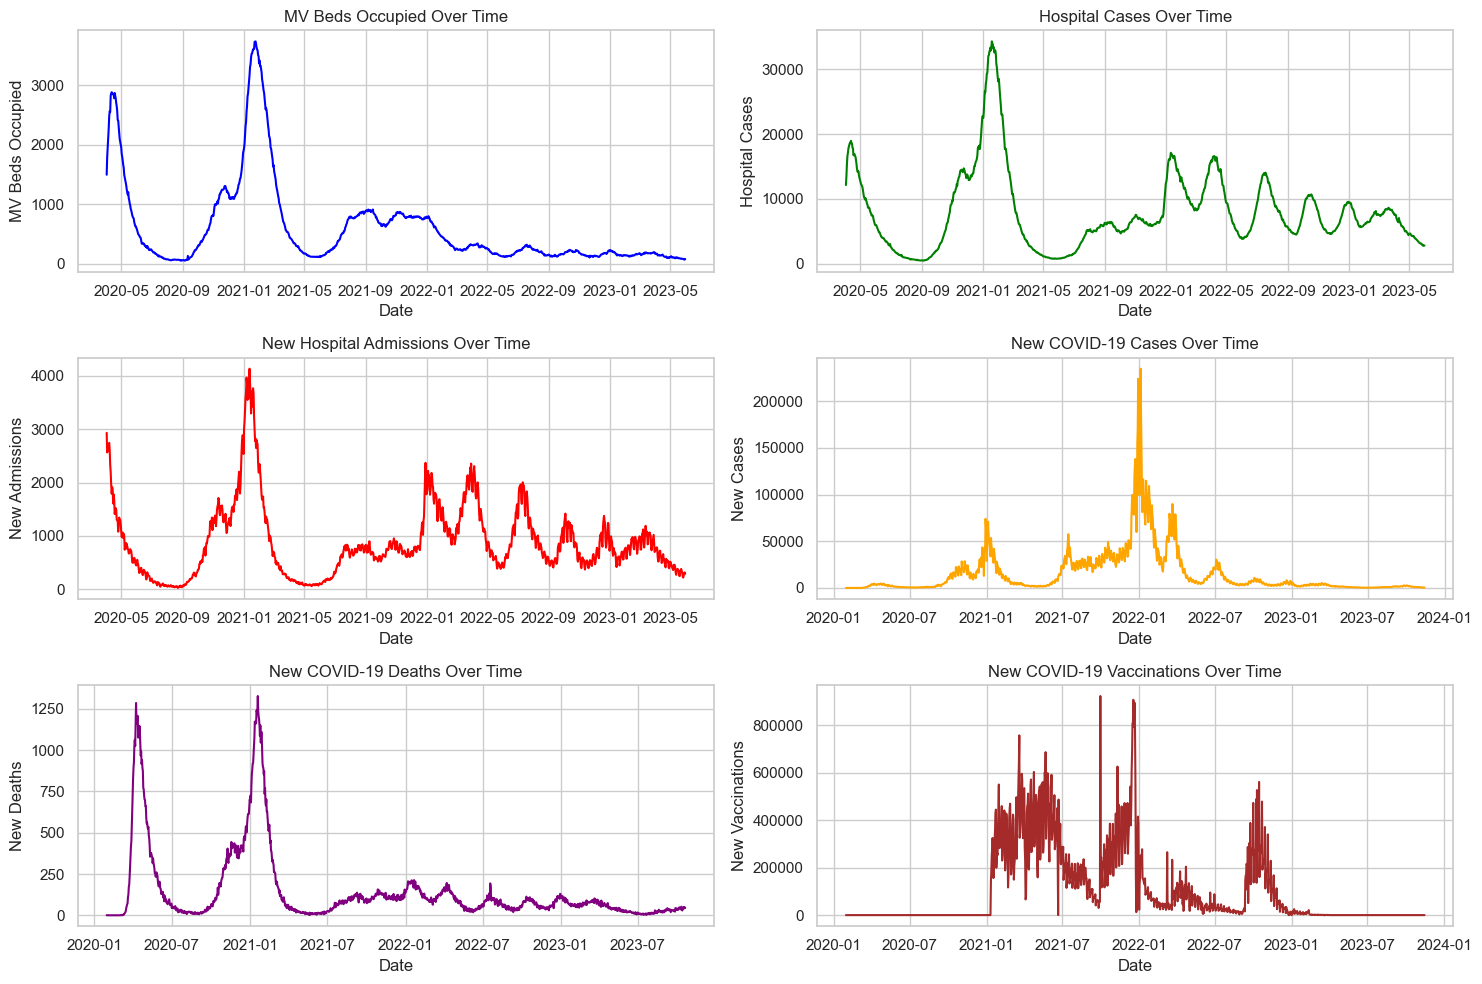

In [14]:
# Setting the visualization style
sns.set(style="whitegrid")

# Visualizing all the data
plt.figure(figsize=(15, 10))

# MV Beds Occupied
plt.subplot(3, 2, 1)
sns.lineplot(data=combined_data, x="Date", y="MV Beds Occupied", color="blue")
plt.title("MV Beds Occupied Over Time")
plt.xlabel("Date")
plt.ylabel("MV Beds Occupied")

# Hospital Cases
plt.subplot(3, 2, 2)
sns.lineplot(data=combined_data, x="Date", y="Hospital Cases", color="green")
plt.title("Hospital Cases Over Time")
plt.xlabel("Date")
plt.ylabel("Hospital Cases")

# New Admissions
plt.subplot(3, 2, 3)
sns.lineplot(data=combined_data, x="Date", y="New Admissions", color="red")
plt.title("New Hospital Admissions Over Time")
plt.xlabel("Date")
plt.ylabel("New Admissions")

# New COVID-19 Cases
plt.subplot(3, 2, 4)
sns.lineplot(data=combined_data, x="Date", y="New COVID-19 Cases", color="orange")
plt.title("New COVID-19 Cases Over Time")
plt.xlabel("Date")
plt.ylabel("New Cases")

# New COVID-19 Deaths
plt.subplot(3, 2, 5)
sns.lineplot(data=combined_data, x="Date", y="New COVID-19 Deaths", color="purple")
plt.title("New COVID-19 Deaths Over Time")
plt.xlabel("Date")
plt.ylabel("New Deaths")

# New Vaccinations
plt.subplot(3, 2, 6)
sns.lineplot(data=combined_data, x="Date", y="New Vaccinations", color="brown")
plt.title("New COVID-19 Vaccinations Over Time")
plt.xlabel("Date")
plt.ylabel("New Vaccinations")

plt.tight_layout()
plt.show()

In [37]:
# Define start and end date for the Alpha variant period
start_alpha = "2020-04-02"
end_alpha = "2020-12-30"

model_data = combined_data.loc[(combined_data["Date"] >= start_alpha) & (combined_data["Date"] <= end_alpha)]
model_data.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,2932.0,4097.0,892.0,0.0
1,2020-04-03,1788.0,13635.0,2564.0,4102.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,2593.0,3405.0,1023.0,0.0
3,2020-04-05,2097.0,16657.0,2592.0,3094.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,2679.0,4407.0,1025.0,0.0


In [38]:
# Example for the High Infection Scenario
model_data["Year"] = model_data["Date"].dt.year
model_data["Month"] = model_data["Date"].dt.month
model_data["Day"] = model_data["Date"].dt.day

# Drop the original 'Date' column
model_data.drop("Date", axis=1, inplace=True)

In [39]:
X = model_data.drop(["New COVID-19 Cases"], axis=1)
y = model_data["New COVID-19 Cases"]

y.head()

0    4097.0
1    4102.0
2    3405.0
3    3094.0
4    4407.0
Name: New COVID-19 Cases, dtype: float64

In [40]:
X.head()

,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Deaths,New Vaccinations,Year,Month,Day
0,1494.0,12135.0,2932.0,892.0,0.0,2020,4,2
1,1788.0,13635.0,2564.0,927.0,0.0,2020,4,3
2,1950.0,15469.0,2593.0,1023.0,0.0,2020,4,4
3,2097.0,16657.0,2592.0,1063.0,0.0,2020,4,5
4,2264.0,17154.0,2679.0,1025.0,0.0,2020,4,6


In [41]:
fh = np.arange(1, 60)
y_train, y_test, X_train, X_pred = temporal_train_test_split(y, X, fh=fh)
# fh = ForecastingHorizon(y_test.index, is_relative=False)

c:\Users\ajaoo\miniconda3\envs\work_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='New COVID-19 Cases'>)

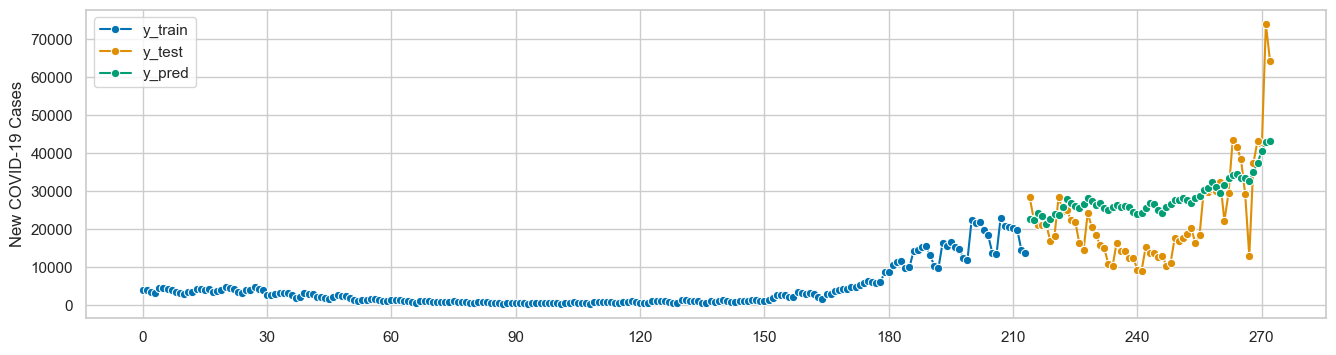

In [42]:
forecaster = AutoARIMA()
forecaster.fit(y_train, X_train)
y_pred = forecaster.predict(fh, X=X_pred)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])

## Scenario Analysis in Forecasting Demand for Mechanical Ventilators

- **Scenerio A (high infection rate)**
- **Scenerio B (Increased Hospitalisation rate)**
- **Scenerio C (Efectiuve Vaccination Campaign)**
- **Scenerio D (Resource Strain)**


In [25]:
# Filter data for 2020 and early 2021
combined_data["Date"] = pd.to_datetime(combined_data["Date"])
data_2020_early_2021 = combined_data[
    (combined_data["Date"].dt.year == 2020)
    | ((combined_data["Date"].dt.year == 2021) & (combined_data["Date"].dt.month <= 4))
]

# High Infection and Hospitalization Scenario
data_high_infection = data_2020_early_2021.copy()
data_high_infection["New COVID-19 Cases"] *= 1.5
data_high_infection["New Admissions"] *= 1.5

# Effective Vaccination Scenario
data_effective_vaccination = data_2020_early_2021.copy()
data_effective_vaccination["New Admissions"] *= 0.7
data_effective_vaccination["MV Beds Occupied"] *= 0.7

# Resource Strain Scenario
data_resource_strain = data_2020_early_2021.copy()
data_resource_strain["Hospital Cases"] *= 1.25
data_resource_strain["MV Beds Occupied"] *= 1.25

In [27]:
data_high_infection.head()

,Date,MV Beds Occupied,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations
0,2020-04-02,1494.0,12135.0,4398.0,6145.5,892.0,0.0
1,2020-04-03,1788.0,13635.0,3846.0,6153.0,927.0,0.0
2,2020-04-04,1950.0,15469.0,3889.5,5107.5,1023.0,0.0
3,2020-04-05,2097.0,16657.0,3888.0,4641.0,1063.0,0.0
4,2020-04-06,2264.0,17154.0,4018.5,6610.5,1025.0,0.0


In [28]:
# Example for the High Infection Scenario
data_high_infection["Year"] = data_high_infection["Date"].dt.year
data_high_infection["Month"] = data_high_infection["Date"].dt.month
data_high_infection["Day"] = data_high_infection["Date"].dt.day

# Drop the original 'Date' column
data_high_infection.drop("Date", axis=1, inplace=True)

In [29]:
# Creating an imputer object with a mean filling strategy
imputer = SimpleImputer(strategy="mean")

In [30]:
X = data_high_infection.drop("MV Beds Occupied", axis=1)
y = data_high_infection["MV Beds Occupied"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [31]:
X_train

,Hospital Cases,New Admissions,New COVID-19 Cases,New COVID-19 Deaths,New Vaccinations,Year,Month,Day
17,16928.0,2212.5,5241.0,967.0,0.0,2020,4,19
66,4820.0,484.5,1002.0,137.0,0.0,2020,6,7
1338,NaN,NaN,828.0,44.0,0.0,2020,3,16
320,17093.0,1966.5,16902.0,501.0,315797.0,2021,2,16
31,12119.0,1566.0,3972.0,556.0,0.0,2020,5,3
...,...,...,...,...,...,...,...,...
106,1346.0,124.5,822.0,31.0,0.0,2020,7,17
270,20426.0,4192.5,61267.5,615.0,0.0,2020,12,28
348,5664.0,546.0,7399.5,94.0,433751.0,2021,3,16
1363,NaN,NaN,0.0,0.0,0.0,2020,2,20


In [32]:
# Training the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Creating a pipeline that first imputes the data then fits the model
pipeline = Pipeline(steps=[("imputation", imputer), ("model", model)])
pipeline.fit(X_train, y_train)

# Making predictions
y_pred = pipeline.predict(X_test)

# Evaluating the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: ", rmse)

ValueError: Input y contains NaN.

In [44]:
import pandas as pd 
import matplotlib.pyplot as plt 
from torch_geometric_temporal.dataset import EnglandCovidDatasetLoader 
from torch_geometric_temporal.signal import temporal_signal_split

ModuleNotFoundError: No module named 'torch_geometric_temporal'

In [45]:
import torch

In [ ]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
from torch_geometric_temporal.signal import temporal_signal_split

loader = ChickenpoxDatasetLoader()

dataset = loader.get_dataset()

train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.2)